In [13]:
from helpers import load_csv_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [ ]:
data_path='data/dataset/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) #float64
print("Data type y_train:", y_train.dtype) #int64

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379


In [ ]:
missing_counts = np.sum(np.isnan(x_train), axis=0)
missing_percents = missing_counts / x_train.shape[0] * 100

output_filename = 'missing_report.csv'
with open(output_filename, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['feature_index', 'missing_count', 'missing_percent'])
    
    for i in range(x_train.shape[1]):  
        writer.writerow([f"Feature_{i}", missing_counts[i], f"{missing_percents[i]:.2f}"])





(328135, 163)


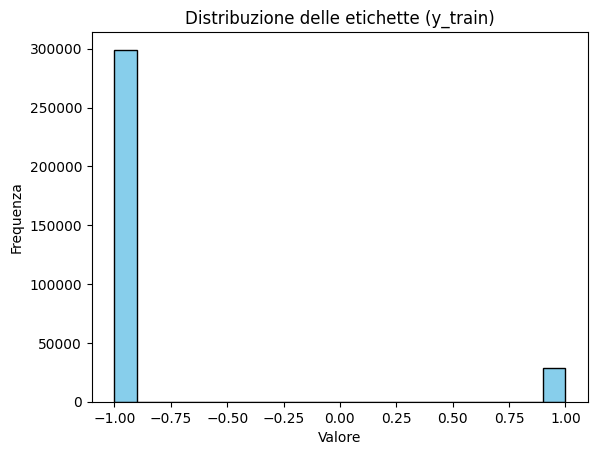

In [ ]:
# y labels distribution
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Data cleaning from NaN

In [11]:
valid_cols = np.where(np.isnan(x_train).sum(axis=0) < 0.4 * x_train.shape[0])[0]
x_train_clean = x_train[:, valid_cols]
print(x_train_clean.shape)

col_mean = np.nanmean(x_train_clean, axis = 0)
inds =np.where(np.isnan(x_train_clean))
x_train_clean[inds] = np.take(col_mean, inds[1])

(328135, 163)


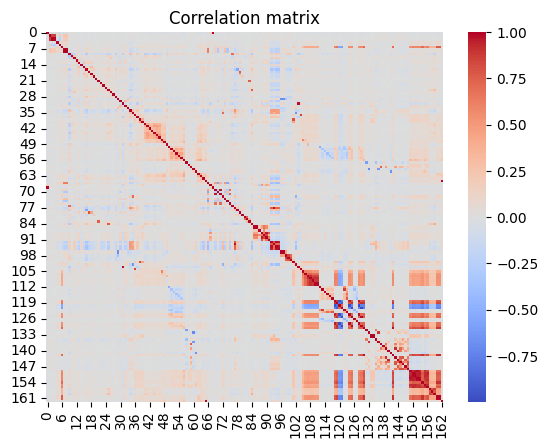

New shape: (328135, 132)


In [15]:
# Cross-correlation among features
def nan_corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            valid_idx = ~np.isnan(X[:, i]) & ~np.isnan(X[:, j])
            if np.sum(valid_idx) > 2:
                corr_ij = np.corrcoef(X[valid_idx, i], X[valid_idx, j])[0,1]
            else:
                corr_ij = np.nan
            corr[i,j] = corr_ij
            corr[j,i] = corr_ij
    return corr

corr_matrix = nan_corrcoef(x_train_clean)

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()

non_valid_col = set()  # Use set to avoid duplicates

for i in range(x_train_clean.shape[1]):
    if i in non_valid_col:
        continue  # Skips if already deleted feature

    for j in range(i + 1, x_train_clean.shape[1]):
        if j in non_valid_col:
            continue  

        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

# Remove column
x_train_new = np.delete(x_train_clean, list(non_valid_col), axis=1)
print(f"New shape: {x_train_new.shape}")